#Read data

In [4]:
%matplotlib inline

import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
    
words=load_simple_json('de/occupation_all.json')#{masculine:[[],[feminine]]}
words_revert={words[i][1]:i for i in words}#feminine:masculine
#neutral=load_simple_json('de/neutral_new.json')

no_page_m=load_simple_json('de/wiki/m_no_page.json')
no_page_f=load_simple_json('de/wiki/f_no_page.json')
#no_page_n=load_simple_json('de/wiki/n_no_page.json')
page_m=load_simple_json('de/wiki/m_page.json')
page_f=load_simple_json('de/wiki/f_page.json')
#page_n=load_simple_json('de/wiki/n_page.json')
m_page_levenshtein=load_simple_json('de/wiki/m_page_levenshtein.json')
#n_page_levenshtein=load_simple_json('de/wiki/n_page_levenshtein.json')


page_f_validated=load_simple_json('de/wiki/f_page_validated.json')
page_f_ambigious=load_simple_json('de/wiki/f_page_ambigious.json')
page_f_other=load_simple_json('de/wiki/f_page_other.json')  
    
page_m_validated=load_simple_json('de/wiki/m_page_validated.json') 
page_m_ambigious=load_simple_json('de/wiki/m_page_ambigious.json')
page_m_other=load_simple_json('de/wiki/m_page_other.json')

#page_n_validated=load_simple_json('de/wiki/n_page_validated.json')
#page_n_ambigious=load_simple_json('de/wiki/n_page_ambigious.json')
#page_n_other=load_simple_json('de/wiki/n_page_other.json') 

m_links_to_feminine=load_simple_json('de/wiki/m_links_to_feminine.json')
m_links_to_smth=load_simple_json('de/wiki/m_links_to_smth.json')
f_links_to_mascuilne=load_simple_json('de/wiki/f_links_to_mascuilne.json')
f_links_to_smth=load_simple_json('de/wiki/f_links_to_smth.json')
#redirection_n=load_simple_json('de/wiki/n_redirects.json')
f_links_to_mascuilne_lev=load_simple_json('de/wiki/f_links_to_mascuilne_lev.json')


googlenumber=load_simple_json('de/googlenumber_new2.json')

##Linear regression

In [5]:
#DEPENDENT VARIABLES:
#masculine exist AND (no feminine OR feminine label redirects to masculine label) => male bias => 1
#feminine exist AND (no masculine OR masculine label redirects to feminine label)  => female bias => 3
#masculine exist AND feminine exist => balanced  => 2


#INDEPENDENT VARIABLES:
#GooglePercent = ((#hits for male label) - (#hits for female label))/(#hits for male label) + (#hits for female label))
                  #normalized difference between google hits of male and female label


    
google_dif={}
for i in googlenumber:
    google_dif[i]=int(googlenumber[i][0])-int(googlenumber[i][1])

google_percent={}
for i in googlenumber:
    sum_m_f=float(int(googlenumber[i][0])+int(googlenumber[i][1]))
    google_percent[i]=(float(googlenumber[i][0])-float(googlenumber[i][1]))/sum_m_f if sum_m_f!=0 else 0


#start with male bias
male_bias_labels=[]
female_bias_labels=[]
no_bias=[]
google_rank_male={}
for i in words:
    if ((i in page_m)&(words[i][1] not in page_f))|((i in page_m)&(i in m_links_to_feminine)):
        male_bias_labels.append(i)
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],1] #1=male bias
    elif ((words[i][1] in page_f)&(i not in page_m))|((words[i][1] in page_f)&(i in f_links_to_mascuilne)):
        female_bias_labels.append(i)
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],3] #3=female bias
        #print i
    elif (i in page_m)&(words[i][1] in page_f):
        no_bias.append(i)
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],2] #2=balanced

print "Male bias:",len(male_bias_labels),", Female bias:",len(female_bias_labels),", No bias:",len(no_bias)
print len(google_rank_male)         



Male bias: 863 , Female bias: 6 , No bias: 6
875


       GoogleResults     GoogleDif  GooglePercent        Wiki
count   8.750000e+02  8.750000e+02     875.000000  875.000000
mean    1.557747e+06  1.516560e+06       0.727126    1.020571
std     9.353227e+06  9.287636e+06       0.358239    0.184123
min     2.300000e+01 -1.251000e+06      -0.957971    1.000000
25%     3.375000e+03  1.967000e+03       0.643823    1.000000
50%     2.490000e+04  1.762700e+04       0.876376    1.000000
75%     2.395000e+05  2.191880e+05       0.961387    1.000000
max     1.610000e+08  1.606710e+08       1.000000    3.000000
GoogleResults    9353226.549176
GoogleDif        9287635.999626
GooglePercent          0.358239
Wiki                   0.184123
dtype: float64


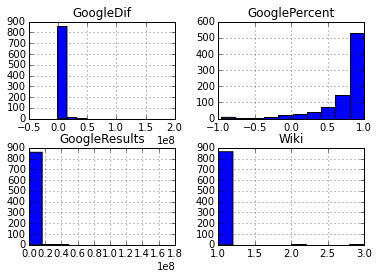

In [6]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

import statsmodels.sandbox as sand



#sm.open_help()


df = pd.DataFrame.from_dict(google_rank_male,orient='index')
df.columns = ['GoogleResults','GoogleDif', 'GooglePercent','Wiki']

# summarize the data
print df.describe()

# take a look at the standard deviation of each column
print df.std()

# frequency table cutting presitge and whether or not someone was admitted
#print pd.crosstab(df['Wiki'], df['GooglePercent'])
# plot all of the columns

df.hist()
pl.show()


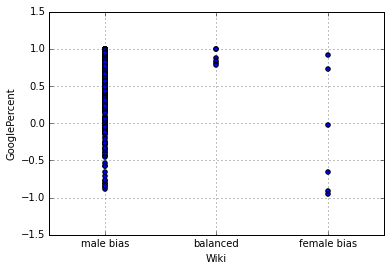

In [7]:
df.plot(x='Wiki', y='GooglePercent', kind='scatter')
pl.xticks([1,2,3],["male bias","balanced","female bias"])
#pl.ylim(0, 1.0)
pl.show()

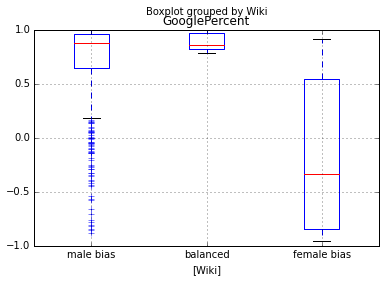

In [8]:
data1= df[['GooglePercent','Wiki']]
#data1.plot( kind='box') 
#pl.figure();
bp = data1.boxplot(by='Wiki')
pl.xticks([1,2,3],["male bias","balanced","female bias"])
pl.show()

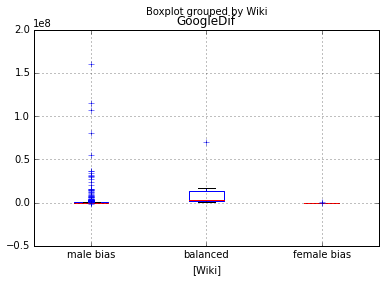

In [173]:
data1= df[['GoogleDif','Wiki']]
#data1.plot( kind='box') 
#pl.figure();
bp = data1.boxplot(by='Wiki')
pl.xticks([1,2,3],["male bias","balanced","female bias"])
pl.show()

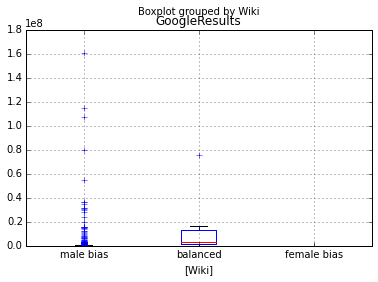

In [174]:
data1= df[['GoogleResults','Wiki']] #google results for male labels
#data1.plot( kind='box') 
#pl.figure();
bp = data1.boxplot(by='Wiki')
pl.xticks([1,2,3],["male bias","balanced","female bias"])
pl.show()

In [182]:
from sklearn import cross_validation



data = df[['GoogleResults', 'GoogleDif', 'GooglePercent']]
data=sm.add_constant(data, prepend=False)
print data.head()
train_cols = data.columns[:4]
#res1 = sm.MNLogit( Y,X)
#res1 = sm.MNLogit( df['Wiki'], data[train_cols])

y=df['Wiki']
X=data[train_cols]


skf = cross_validation.StratifiedKFold(y, n_folds=3,shuffle=True)
for train_index, test_index in skf:  
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X.GooglePercent[train_index], X.GooglePercent[test_index] 
    #X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]#X.iloc[0,:] <- for all columns
    #print "train:",X_train,"==test", X_test
    #print "train:",(y_train), "test:",(y_test)
    print "train:",len(y_train), "test:",len(y_test)
    res1 = sm.MNLogit(y_train, X_train) 
    mlogit_res = res1.fit()
    print mlogit_res.params
    print mlogit_res.summary()
    #inter, slope=mlogit_res.params
    #print inter+ages.mean()*slope

    ### aic and bic ###
    print "AIC:",mlogit_res.aic
    print "BIC:",mlogit_res.bic
    
    mlogit_margeff = mlogit_res.get_margeff()
    #print mlogit_margeff.summary()

    predict= np.array(mlogit_res.predict() > 0.5, dtype=float)
    #print predict
    
    #pred_table[i,j] refers to the number of times "i" was observed and
    #the model predicted "j". Correct predictions are along the diagonal.
    print mlogit_res.pred_table()
    acc=float(sum(mlogit_res.pred_table().diagonal()))/float(len(y_train))
    print "Accuracy:",acc
    




#columns =['GoogleResults', 'GoogleDif', 'GooglePercent',"const"]#['GoogleResults', 'GoogleDif', 'GooglePercent']
#new = pd.DataFrame([[10000, 1000, -0.8, 1]], columns=columns)
#new_y = (mlogit_res.predict(new)>=0.5)
#print new_y*[1,2,3]  

'''
columns =['GooglePercent'] 
new = pd.DataFrame([[ 0.8]], columns=columns)

new_y =  np.array(mlogit_res.predict(new)>=0.5, dtype=float)
print new_y
prediction=mlogit_res.predict(new)
'''

                         GoogleResults  GoogleDif  GooglePercent  const
Fahrzeuginnenausstatter           3130       2870       0.846608      1
Revisor                         858000     852360       0.986939      1
Tapezierer                       50600      49874       0.971710      1
Jäger                          2350000    2301800       0.959803      1
Zusteller                       596000     591750       0.985839      1
train: 583 test: 292
Optimization terminated successfully.
         Current function value: 0.274751
         Iterations 7
                      0         1
GooglePercent -4.823645 -5.288738
                          MNLogit Regression Results                          
Dep. Variable:                   Wiki   No. Observations:                  583
Model:                        MNLogit   Df Residuals:                      581
Method:                           MLE   Df Model:                            0
Date:                Thu, 23 Jul 2015   Pseudo R-squ.:       

"\ncolumns =['GooglePercent'] \nnew = pd.DataFrame([[ 0.8]], columns=columns)\n\nnew_y =  np.array(mlogit_res.predict(new)>=0.5, dtype=float)\nprint new_y\nprediction=mlogit_res.predict(new)\n"

In [172]:
'''
new=[]
print new
for i,j in enumerate(y_test): 
    if j==1:
        new.append(np.array([1,0,0]))
    elif j==2:
        new.append(np.array([0,1,0]))
    elif j==3:
        new.append(np.array([0,0,1]))
new=np.array(new)




import numpy as np
pred = np.array(mlogit_res.predict(y_test) > 0.5, dtype=float)
table = np.histogram2d(new, pred, bins=2)[0]
print table '''

'\nnew=[]\nprint new\nfor i,j in enumerate(y_test): \n    if j==1:\n        new.append(np.array([1,0,0]))\n    elif j==2:\n        new.append(np.array([0,1,0]))\n    elif j==3:\n        new.append(np.array([0,0,1]))\nnew=np.array(new)\n\n\n\n\nimport numpy as np\npred = np.array(mlogit_res.predict(y_test) > 0.5, dtype=float)\ntable = np.histogram2d(new, pred, bins=2)[0]\nprint table '

In [125]:
new_=[]
for i in range(0,len(pred)):
    new_.append([k for k, e in enumerate(pred[i]) if e != 0][0]+1)

new_array=np.array(new_)
len(new_array)

145

In [26]:

# manually add the intercept
data = df[['GoogleResults', 'GoogleDif', 'GooglePercent']]
data=sm.add_constant(data, prepend=False)
print data.head()
train_cols = data.columns[:4]
#res1 = sm.MNLogit( Y,X)
res1 = sm.MNLogit( df['Wiki'], data[train_cols])

mlogit_res = res1.fit()
print mlogit_res.params
mlogit_margeff = mlogit_res.get_margeff()
print mlogit_margeff.summary()

                         GoogleResults  GoogleDif  GooglePercent  const
Fahrzeuginnenausstatter           3130       2870       0.846608      1
Revisor                         858000     852360       0.986939      1
Tapezierer                       50600      49874       0.971710      1
Jäger                          2350000    2301800       0.959803      1
Zusteller                       596000     591750       0.985839      1
Optimization terminated successfully.
         Current function value: 0.064070
         Iterations 15
                      0         1
GoogleResults  0.000003 -0.000001
GoogleDif     -0.000003 -0.000001
GooglePercent  3.591491 -2.655583
const         -8.322106 -3.833086
       MNLogit Marginal Effects      
Dep. Variable:                   Wiki
Method:                          dydx
At:                           overall
       Wiki=1      dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------

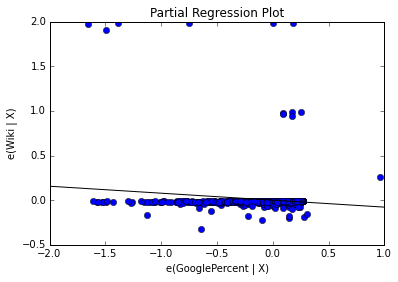

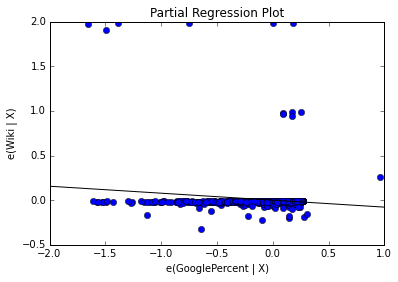

In [27]:
sm.graphics.plot_partregress('Wiki', 'GooglePercent', ['GoogleDif', 'GoogleResults'], data=df, obs_labels=False)

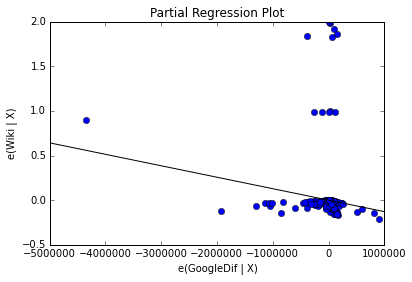

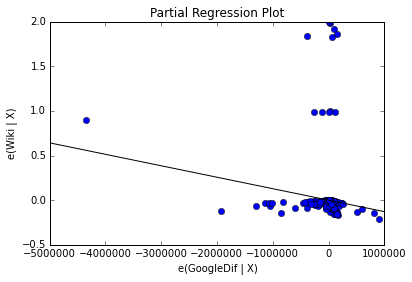

In [28]:
sm.graphics.plot_partregress('Wiki', 'GoogleDif', ['GooglePercent', 'GoogleResults'], data=df, obs_labels=False)

In [29]:
# odds ratios only
print np.exp(mlogit_res.params)

                       0         1
GoogleResults   1.000003  0.999999
GoogleDif       0.999997  0.999999
GooglePercent  36.288158  0.070258
const           0.000243  0.021643


In [24]:
#pd.save(df, 'de/values_googlenumber_pred.csv')

#!!!END is here=======

#Prediction function #old

In [90]:
#prediction function

import numpy as np
from scipy import interp

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cross_validation import train_test_split,StratifiedKFold
from sklearn.metrics import roc_curve, auc
def predict_linear_regr(df,C_val=1e5,multi_class='ovr',n=1):#'multinomial'
    X = df.get_values()[:,:n] # we only take the first two features.
    Y = df.Wiki
    skf = StratifiedKFold(Y, n_folds=3)
    logreg = linear_model.LogisticRegression(C=C_val,solver='newton-cg',multi_class='multinomial')# lbfgs’ & ‘newton-cg’ solvers
    mean_tpr=0.0
    mean_fpr = np.linspace(0, 1, 100)
    i=1
    plt.figure()
    for train_index, test_index in skf:
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        print "train set:",len(y_train)," test set:", len(y_test)
        #print y_train," test:", y_test
        logr= logreg.fit(X_train, y_train)
        probas_=logr.predict_proba(X_test)
        # Compute ROC curve and area the curve
        print probas_
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],pos_label =1)
        #roc_curve(y_test[:, i], y_score[:, i])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i+=1
        scores = cross_validation.cross_val_score(logr, X_train, y_train, cv=5)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    # we create an instance of Neighbours Classifier and fit the data.
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    print "train and test data size:",X_train.shape, X_test.shape
    logreg_fit=logreg.fit(X_train, y_train)
    
    
    
    scores = cross_validation.cross_val_score(logreg_fit, X, Y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    #print logreg_fit.intercept_
    y_pred = logreg_fit.predict(X_test)
    
    print"{0} / {1} correct ({2})".format(np.sum(y_test == y_pred), len(y_test),np.sum(y_test == y_pred)/float(len(y_test)))
    print y_pred.score(X_test, y_test) 
    #print ROC curve labels
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    mean_tpr /= len(skf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend()
    plt.show()
    
    #return probas_
    return y_pred

train set: 583  test set: 292
[[  6.06796302e-001   1.64411250e-001   2.28792448e-001]
 [  5.00962457e-001   4.99037129e-001   4.13725563e-007]
 [  6.55866727e-001   2.11933421e-001   1.32199852e-001]
 [  5.00000008e-001   4.99999992e-001   4.26194872e-017]
 [  5.07547471e-001   4.92428143e-001   2.43860537e-005]
 [  6.09588351e-001   1.64035960e-001   2.26375689e-001]
 [  5.93909799e-001   1.97903264e-001   2.08186937e-001]
 [  5.88190048e-001   1.78669042e-001   2.33140910e-001]
 [  6.07828606e-001   1.68134525e-001   2.24036869e-001]
 [  5.76570599e-001   4.19409163e-001   4.02023778e-003]
 [  6.01622820e-001   1.90531854e-001   2.07845325e-001]
 [  6.28639817e-001   1.66116367e-001   2.05243816e-001]
 [  5.00000000e-001   5.00000000e-001   0.00000000e+000]
 [  4.24184448e-001   2.75982455e-001   2.99833098e-001]
 [  5.12218742e-001   4.87716883e-001   6.43748049e-005]
 [  6.16838895e-001   1.60332519e-001   2.22828587e-001]
 [  6.13756016e-001   1.57806920e-001   2.28437063e-001]
 

AttributeError: 'numpy.ndarray' object has no attribute 'score'

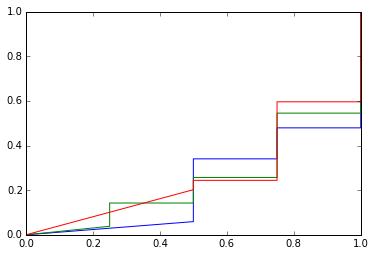

In [92]:

res2=predict_linear_regr(df,n=3)
for i in res2:
    if i!=1:
        print i

## old #simple Google hits, predict if wiki page exist

In [3]:
#dependent var
#(i) has WP article entry with text (real article), #1
#(ii) has entry that is a redirect to other gender profession name, #2
#(iii) has entry that is a redirect to something else, #3
#(iv) has no entry at all #4
#use as independent vars /predictors:
#(i) total number of google hits, 
#(ii) relative hits in relation to gender counterpart 
#            (i would suggest to just sum up hits for male and female and take the percentage for the target gender), 
#(iii) chars in profession name (just for control)


#male
google_rank_male={}
for i in words:
    if (i in page_m_validated):
        google_rank_male[i]=[int(googlenumber[i][0]),1]
    elif (i in m_links_to_feminine):
        google_rank_male[i]=[int(googlenumber[i][0]),2]
    elif (i in m_links_to_smth) :#3
        google_rank_male[i]=[int(googlenumber[i][0]),3]
    #elif (i in no_page_m):
    else:
        google_rank_male[i]=[int(googlenumber[i][0]),4]

        
        
len(google_rank_male)
import pandas as pd
df = pd.DataFrame.from_dict(google_rank_male,orient='index')
df.columns = ['GoogleResults', 'Wiki']
res1=predict_linear_regr(df)

for i in res1:
    if i!=4:
        print 'Not equal "4": ',i

C:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:157: UserWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


train and test data size: (3123, 1) (1041, 1)
740 / 1041 correct (0.710854947166)
Last 90 predicted values: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [31]:
google_dif={}
for i in googlenumber:
    google_dif[i]=int(googlenumber[i][0])-int(googlenumber[i][1])

google_percent={}
for i in googlenumber:
    sum_m_f=float(int(googlenumber[i][0])+int(googlenumber[i][1]))
    google_percent[i]=100*float(googlenumber[i][0])/sum_m_f if sum_m_f!=0 else 0
#start with male bias
google_rank_male={}
for i in words:
    if (i in page_m):
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],1]
    elif (i in m_links_to_feminine):
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],2]
    elif (i in m_links_to_smth) :#3
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],3]
    elif (i in no_page_m):
        google_rank_male[i]=[int(googlenumber[i][0]),google_dif[i],google_percent[i],4]

len(google_rank_male)

import pandas as pd
df = pd.DataFrame.from_dict(google_rank_male,orient='index')
df.columns = ['GoogleResults','GoogleDif', 'GooglePercent','Wiki']
res2=predict_linear_regr(df,n=3)
n=0
for i in res2:
    if i!=4:
        n+=1
print 'Not equal  "4" {0} times'.format(n)

train and test data size: (3123, 3) (1041, 3)
734 / 1041 correct (0.705091258405)
Last 90 predicted values: [4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 1 4 4 4 1 4 4 4 4 4
 4 1 4 1 4 4 4 4 4 4 4 4 1 4 4 4 4 4 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Not equal  "4" 73 times


###Prediction example

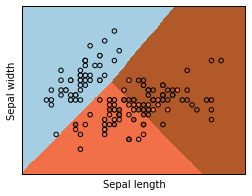

In [3]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

h = .02  # step size in the mesh

logreg = linear_model.LogisticRegression(C=1e5)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

##  not relevant - examples

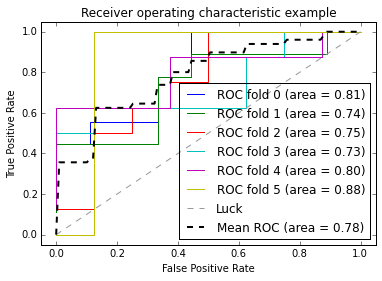

In [8]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

###############################################################################
# Data IO and generation

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

###############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [111]:
anes_data = sm.datasets.anes96.load()
anes_exog = anes_data.exog

anes_exog = sm.add_constant(anes_exog, prepend=False)

res1 = sm.MNLogit(anes_data.endog, anes_exog)

mlogit_res = res1.fit()
print mlogit_res.params
mlogit_margeff = mlogit_res.get_margeff()
print mlogit_margeff.summary()

#print res1.summary()

#res1.predict(x.mean(0))

Optimization terminated successfully.
         Current function value: 1.548647
         Iterations 7
[[ -1.15359746e-02  -8.87506530e-02  -1.05966699e-01  -9.15567017e-02
   -9.32846040e-02  -1.40880692e-01]
 [  2.97714352e-01   3.91668642e-01   5.73450508e-01   1.27877179e+00
    1.34696165e+00   2.07008014e+00]
 [ -2.49449954e-02  -2.28978371e-02  -1.48512069e-02  -8.68134503e-03
   -1.79040689e-02  -9.43264870e-03]
 [  8.24914421e-02   1.81042758e-01  -7.15241904e-03   1.99827955e-01
    2.16938850e-01   3.21925702e-01]
 [  5.19655317e-03   4.78739761e-02   5.75751595e-02   8.44983753e-02
    8.09584122e-02   1.08894083e-01]
 [ -3.73401677e-01  -2.25091318e+00  -3.66558353e+00  -7.61384309e+00
   -7.06047825e+00  -1.21057509e+01]]
       MNLogit Marginal Effects      
Dep. Variable:                      y
Method:                          dydx
At:                           overall
       y=0      dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------

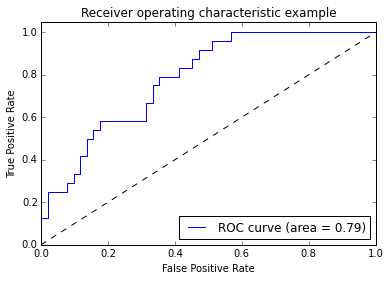

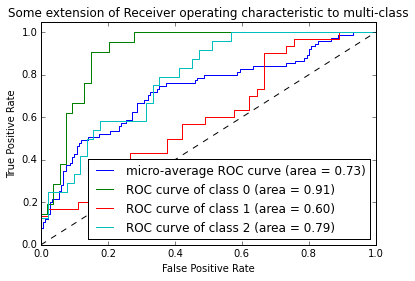

In [7]:
####Example
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# %load C:\Users\zagovooa\Documents\GitHub\scipy_2015_sklearn_tutorial\fetch_data.py